# Import Statements

In [113]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# carry out one hot encoding
from feature_engine.encoding import OneHotEncoder

# Import Scalers
# for min-max scaling
from sklearn.preprocessing import MinMaxScaler
# for standardization
from sklearn.preprocessing import StandardScaler
# for robust scaling
from sklearn.preprocessing import RobustScaler

# import XGBRegressor from xgboost package
from xgboost import XGBRegressor

# to evaluate model metrics
from sklearn.metrics import mean_squared_error, r2_score

# import grid search cv to improve decision tree model by helping search for parameters
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session

# to export model
import joblib

from pyspark.sql.functions import year

import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

# Functions

In [114]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [115]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "raw_pos",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

In [116]:
# retrieve order details usa table from snowflake
order_detail = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_DETAIL")
order_header = session.table("frostbyte_tasty_bytes.raw_pos.ORDER_HEADER")

In [117]:
order_detail.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_DETAIL_ID"  |"ORDER_ID"  |"MENU_ITEM_ID"  |"DISCOUNT_ID"  |"LINE_NUMBER"  |"QUANTITY"  |"UNIT_PRICE"  |"PRICE"  |"ORDER_ITEM_DISCOUNT_AMOUNT"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------
|716664763          |390479600   |17              |NULL           |0              |5           |4.0000        |20.0000  |NULL                          |
|716664764          |390479600   |18              |NULL           |1              |1           |5.0000        |5.0000   |NULL                          |
|716664765          |390479600   |19              |NULL           |2              |2           |3.0000        |6.0000   |NULL                          |
|716664766          |390479600   |12              |NULL           |3              

In [118]:
order_header.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|14271673    |90          |2666.0         |NULL           |NULL           |63645       |15:30:00            |22:30:00          |NULL             |2021-05-

In [119]:
# Merge the two tables using the 'ORDER_ID' column as the common key
merged_df = order_detail.join(order_header, on='ORDER_ID', how='inner')

In [120]:
order_df = merged_df.select("MENU_ITEM_ID", "QUANTITY", "ORDER_TS")

In [121]:
# Convert the 'ORDER_TS' column to a java.sql.Timestamp object
order_df = order_df.withColumn('ORDER_TS', F.to_timestamp(order_df['ORDER_TS']))

# Extract the year from the 'ORDER_TS' column
order_df = order_df.withColumn('YEAR', F.year(order_df['ORDER_TS']))

# Drop the 'ORDER_TS' column
order_df = order_df.drop('ORDER_TS')

# Show the modified DataFrame with the 'YEAR' column
order_df.show()

----------------------------------------
|"MENU_ITEM_ID"  |"QUANTITY"  |"YEAR"  |
----------------------------------------
|63              |1           |2021    |
|63              |4           |2021    |
|62              |1           |2021    |
|62              |2           |2021    |
|61              |1           |2021    |
|62              |1           |2021    |
|62              |3           |2021    |
|63              |1           |2021    |
|65              |2           |2021    |
|66              |2           |2021    |
----------------------------------------



In [122]:
# Group by 'YEAR' and 'MENU_ITEM_ID' and calculate the sum of 'QUANTITY'
total_qty_by_item = order_df.group_by(['YEAR', 'MENU_ITEM_ID']) \
                           .agg(F.sum(order_df['QUANTITY']).alias('TOTAL_QTY_SOLD_PER_YEAR')) \
                           .orderBy(['YEAR', 'MENU_ITEM_ID'])

# View the data
total_qty_by_item.show()

-------------------------------------------------------
|"YEAR"  |"MENU_ITEM_ID"  |"TOTAL_QTY_SOLD_PER_YEAR"  |
-------------------------------------------------------
|2019    |10              |78792                      |
|2019    |11              |232642                     |
|2019    |12              |233539                     |
|2019    |13              |232888                     |
|2019    |14              |78885                      |
|2019    |15              |78516                      |
|2019    |16              |78613                      |
|2019    |17              |232796                     |
|2019    |18              |232653                     |
|2019    |19              |232649                     |
-------------------------------------------------------



In [123]:
order_df_grp_by = total_qty_by_item.to_pandas()

# Menu Table 

In [124]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU")

In [125]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = menu_data_from_snowflake.to_pandas()

In [126]:
# merge total_qty_sold_per_item with final_product_df
menu_df = pd.merge(menu_df, order_df_grp_by, on='MENU_ITEM_ID')

In [127]:
# preview menu table
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,MENU_ITEM_HEALTH_METRICS_OBJ,YEAR,TOTAL_QTY_SOLD_PER_YEAR
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,78792
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2020,304815
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2021,862402
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,"{\n ""menu_item_health_metrics"": [\n {\n ...",2022,1568416
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,"{\n ""menu_item_health_metrics"": [\n {\n ...",2019,232642


In [128]:
# Convert the string JSON data to a nested dictionary
menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'] = menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'].apply(ast.literal_eval)

# Use json_normalize to flatten the nested JSON data
menu_item_metrics = pd.json_normalize(menu_df['MENU_ITEM_HEALTH_METRICS_OBJ'], record_path='menu_item_health_metrics')

# Rename the columns
menu_item_metrics = menu_item_metrics.rename(columns={
    'is_dairy_free_flag': 'DAIRY_FREE',
    'is_gluten_free_flag': 'GLUTEN_FREE',
    'is_healthy_flag': 'HEALTHY',
    'is_nut_free_flag': 'NUT_FREE'
})

# Replace 'Y' with 'Yes' and 'N' with 'No' in the DataFrame
menu_item_metrics = menu_item_metrics.replace({'Y': 1, 'N': 0})

# Concatenate the flattened DataFrame with the original DataFrame
menu_df = pd.concat([menu_df, menu_item_metrics], axis=1)

# Drop the original 'MENU_ITEM_HEALTH_METRICS_OBJ' and 'ingredients' column 
menu_df = menu_df.drop(columns=['MENU_ITEM_HEALTH_METRICS_OBJ', 'ingredients'])

In [129]:
menu_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,78792,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,304815,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,862402,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,1568416,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,232642,1,1,0,1


# Final Table

In [130]:
final_df = menu_df

In [131]:
final_df.head()

,MENU_ID,MENU_TYPE_ID,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,MENU_ITEM_NAME,ITEM_CATEGORY,ITEM_SUBCATEGORY,COST_OF_GOODS_USD,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2019,78792,1,1,0,1
1,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2020,304815,1,1,0,1
2,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2021,862402,1,1,0,1
3,10001,1,Ice Cream,Freezing Point,10,Lemonade,Beverage,Cold Option,0.65,3.5,2022,1568416,1,1,0,1
4,10002,1,Ice Cream,Freezing Point,11,Sugar Cone,Dessert,Cold Option,2.50,6.0,2019,232642,1,1,0,1


In [132]:
final_df['TOTAL_QTY_SOLD_PER_YEAR'] = final_df['TOTAL_QTY_SOLD_PER_YEAR'].astype(int)

In [133]:
# Calculate the minimum and maximum values of the 'TOTAL_QTY_SOLD' column
min_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].min()
max_value = final_df['TOTAL_QTY_SOLD_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 32277 - 9753474


In [134]:
final_df = final_df.drop(["COST_OF_GOODS_USD", "MENU_ID", "MENU_TYPE_ID", "MENU_ITEM_NAME"], axis=1)
final_df.head()

,MENU_TYPE,TRUCK_BRAND_NAME,MENU_ITEM_ID,ITEM_CATEGORY,ITEM_SUBCATEGORY,SALE_PRICE_USD,YEAR,TOTAL_QTY_SOLD_PER_YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE
0,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2019,78792,1,1,0,1
1,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2020,304815,1,1,0,1
2,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2021,862402,1,1,0,1
3,Ice Cream,Freezing Point,10,Beverage,Cold Option,3.5,2022,1568416,1,1,0,1
4,Ice Cream,Freezing Point,11,Dessert,Cold Option,6.0,2019,232642,1,1,0,1


# Check for Missing Values

In [135]:
final_df.isnull().sum()

MENU_TYPE                  0
TRUCK_BRAND_NAME           0
MENU_ITEM_ID               0
ITEM_CATEGORY              0
ITEM_SUBCATEGORY           0
SALE_PRICE_USD             0
YEAR                       0
TOTAL_QTY_SOLD_PER_YEAR    0
DAIRY_FREE                 0
GLUTEN_FREE                0
HEALTHY                    0
NUT_FREE                   0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

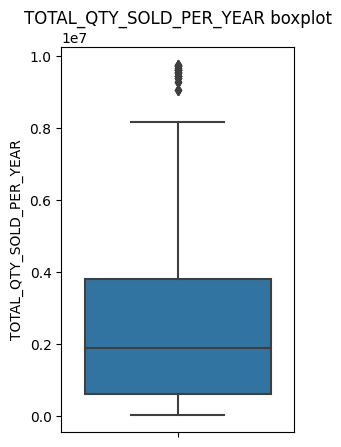

In [136]:
# plot box plot for 'minimum_nights' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_QTY_SOLD_PER_YEAR'])
plt.title('TOTAL_QTY_SOLD_PER_YEAR boxplot')
plt.show()

Based on the boxplot shown above, there are no outliers detected. Hence, no process required for this stage.

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of menu items, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [137]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_QTY_SOLD_PER_YEAR', axis=1), final_df['TOTAL_QTY_SOLD_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((254, 11), (110, 11))

# Categorical Variable Encoding 

In [138]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [139]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode

ohe_enc.fit(X_train)

c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return is_datetime(pd.to_datetime(column, errors="ignore", utc=True))
c:\Users\donsu\.conda\envs\py38_env\lib\site-packages\feature_engine\variable_handling\_variable_type_checks.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consisten

OneHotEncoder(drop_last=True)

In [140]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [141]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
# Save the model to a file
joblib.dump(scaler, "StreamlitApp/assets/product_qty_per_month_min_max_scaler.joblib")

['StreamlitApp/assets/product_qty_per_month_min_max_scaler.joblib']

## Standard Scaler

In [143]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [144]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [145]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Model

In [146]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  598224.3244574417
the testing root mean squared error is:  606089.6426365215

the training mean squared error is:  357872342372.5625
the testing mean squared error is:  367344654911.26636

training accuracy is:  0.9590439815926386
testing accuracy is:  0.9499170360083301


# Improve Model (GridSearch CV)

In [147]:
param_grid = {'n_estimators': [10, 20, 30, 40],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [3,4,5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

best_params = xgb_grid.best_params_
print("Best parameters found: ", best_params)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 40}
Best score found:  0.9876748753087332


# Improved Model Results

In [148]:
# Build XGBoost Model
xgb_improved = XGBRegressor(**best_params)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  34039.03675943714
the testing root mean squared error is:  188069.68330871686

the training mean squared error is:  1158656023.510313
the testing mean squared error is:  35370205779.84106

training accuracy is:  0.9998673998188513
testing accuracy is:  0.995177703775552


In [149]:
xgb_improved.feature_importances_

array([4.46910001e-02, 3.48950416e-01, 1.27746671e-01, 2.33810904e-04,
       8.03137384e-03, 6.63386090e-05, 1.20789360e-03, 1.59795512e-04,
       6.71910937e-04, 2.17059045e-03, 3.82579141e-03, 9.89791122e-04,
       8.81636224e-04, 4.80844115e-04, 8.34751583e-04, 0.00000000e+00,
       8.50808574e-04, 4.68506594e-04, 1.78836926e-03, 0.00000000e+00,
       6.87983062e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.07857448e-03,
       3.30806345e-01, 0.00000000e+00, 5.22125745e-04, 1.19854674e-01],
      dtype=float32)

In [150]:
# Get the feature importances
feature_importance = xgb_improved.feature_importances_

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importance_df)

                                  Feature  Importance
1                          SALE_PRICE_USD    0.348950
36                 ITEM_CATEGORY_Beverage    0.330806
2                                    YEAR    0.127747
39           ITEM_SUBCATEGORY_Cold Option    0.119855
0                            MENU_ITEM_ID    0.044691
4                             GLUTEN_FREE    0.008031
35                     ITEM_CATEGORY_Main    0.004079
10                   MENU_TYPE_Vegetarian    0.003826
9                         MENU_TYPE_Gyros    0.002171
18                     MENU_TYPE_Hot Dogs    0.001788
6                                NUT_FREE    0.001208
11                      MENU_TYPE_Chinese    0.000990
12                       MENU_TYPE_Crepes    0.000882
16                        MENU_TYPE_Ramen    0.000851
14                        MENU_TYPE_Tacos    0.000835
20                          MENU_TYPE_BBQ    0.000688
8                       MENU_TYPE_Poutine    0.000672
38            ITEM_SUBCATEGO

In [151]:
X_train.head()

,MENU_ITEM_ID,SALE_PRICE_USD,YEAR,DAIRY_FREE,GLUTEN_FREE,HEALTHY,NUT_FREE,MENU_TYPE_Grilled Cheese,MENU_TYPE_Poutine,MENU_TYPE_Gyros,...,TRUCK_BRAND_NAME_Kitakata Ramen Bar,TRUCK_BRAND_NAME_Nani's Kitchen,TRUCK_BRAND_NAME_Amped Up Franks,TRUCK_BRAND_NAME_Better Off Bread,TRUCK_BRAND_NAME_Smoky BBQ,ITEM_CATEGORY_Main,ITEM_CATEGORY_Beverage,ITEM_CATEGORY_Dessert,ITEM_SUBCATEGORY_Hot Option,ITEM_SUBCATEGORY_Cold Option
150,61,5.0,2021,0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,1,0
278,116,3.0,2021,1,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1
283,122,12.0,2020,1,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
173,71,9.0,2020,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
275,115,3.0,2021,1,1,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [152]:
X_train.columns

Index(['MENU_ITEM_ID', 'SALE_PRICE_USD', 'YEAR', 'DAIRY_FREE', 'GLUTEN_FREE',
       'HEALTHY', 'NUT_FREE', 'MENU_TYPE_Grilled Cheese', 'MENU_TYPE_Poutine',
       'MENU_TYPE_Gyros', 'MENU_TYPE_Vegetarian', 'MENU_TYPE_Chinese',
       'MENU_TYPE_Crepes', 'MENU_TYPE_Ethiopian', 'MENU_TYPE_Tacos',
       'MENU_TYPE_Ice Cream', 'MENU_TYPE_Ramen', 'MENU_TYPE_Indian',
       'MENU_TYPE_Hot Dogs', 'MENU_TYPE_Sandwiches', 'MENU_TYPE_BBQ',
       'TRUCK_BRAND_NAME_The Mega Melt',
       'TRUCK_BRAND_NAME_Revenge of the Curds',
       'TRUCK_BRAND_NAME_Cheeky Greek', 'TRUCK_BRAND_NAME_Plant Palace',
       'TRUCK_BRAND_NAME_Peking Truck', 'TRUCK_BRAND_NAME_Le Coin des Crêpes',
       'TRUCK_BRAND_NAME_Tasty Tibs', 'TRUCK_BRAND_NAME_Guac n' Roll',
       'TRUCK_BRAND_NAME_Freezing Point',
       'TRUCK_BRAND_NAME_Kitakata Ramen Bar',
       'TRUCK_BRAND_NAME_Nani's Kitchen', 'TRUCK_BRAND_NAME_Amped Up Franks',
       'TRUCK_BRAND_NAME_Better Off Bread', 'TRUCK_BRAND_NAME_Smoky BBQ',
       'ITEM